# Examples: point clouds

In [1]:
import importlib
from pprint import pprint
import sys
sys.path.append('..')

from ipywidgets import interact
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
import psdist as ps
import psdist.visualization as psv
from scipy import interpolate

In [2]:
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'
pplt.rc['figure.facecolor'] = 'white'
pplt.rc['grid'] = False

Make a six-dimensional distribution.

In [3]:
n = 6
k = int(1e5)
dims = ["x", "px", "y", "py", "z", "pz"]

state = np.random.RandomState(1950)
_Sigma = np.identity(n)
for i in range(n):
    for j in range(i):
        _Sigma[i, j] = _Sigma[j, i] = state.uniform(-0.2, 0.2)
X = state.multivariate_normal(np.zeros(n), _Sigma, size=k)
for _ in range(4):
    scale = state.uniform(0.5, 1.5, size=n)
    loc = state.uniform(-3.0, 3.0, size=n)
    X = np.vstack([X, state.normal(loc=loc, scale=scale, size=(k, n))])
X = X - np.mean(X, axis=0)

## 2D plotting

In [4]:
axis = (0, 1)
_X = ps.cloud.downsample(X[:, axis], 1000)
_dims = [dims[k] for k in axis]

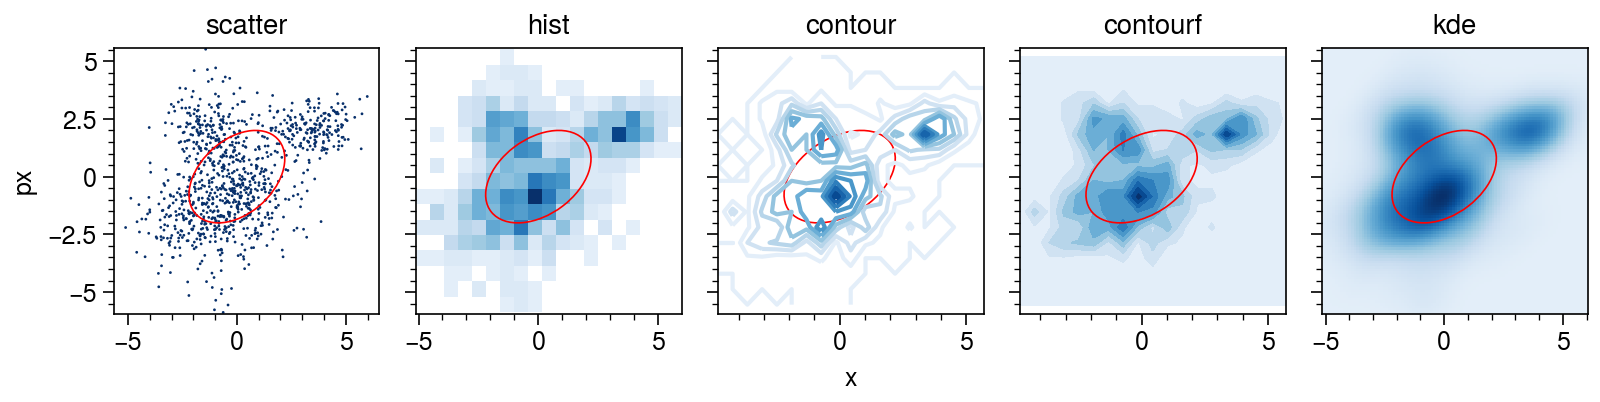

In [5]:
cmap = pplt.Colormap('blues', left=0.1)
kinds = ['scatter', 'hist', 'contour', 'contourf', 'kde']

fig, axs = pplt.subplots(ncols=len(kinds), figwidth=8.0)
for ax, kind in zip(axs, kinds):
    kws = dict()
    if kind == 'scatter':
        kws['c'] = cmap(1.0)
        kws['s'] = 1.0
    else:
        kws['cmap'] = cmap
    psv.cloud.plot2d(
        _X, ax=ax, kind=kind,
        rms_ellipse=True, 
        rms_ellipse_kws=dict(color='red'),
        **kws
    )
    ax.format(title=kind)
axs.format(xlabel=_dims[0], ylabel=_dims[1])

### Enclosing sphere/ellipsoid 

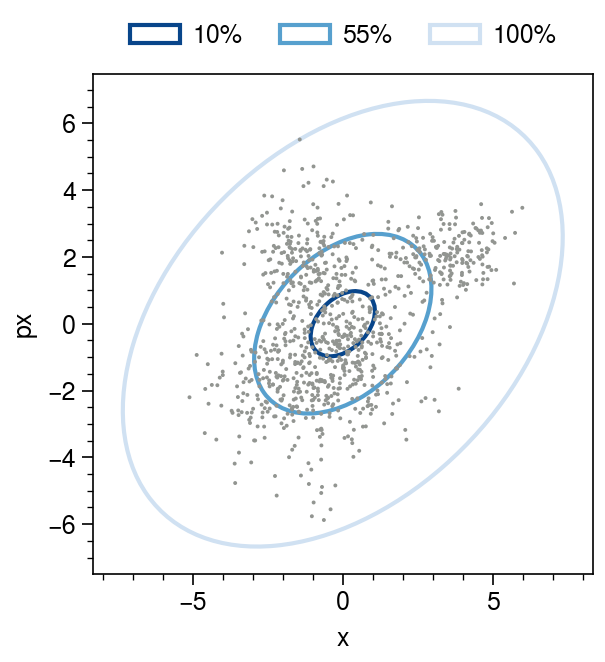

In [6]:
fig, ax = pplt.subplots()
psv.cloud.plot2d(_X, ax=ax, kind='scatter', c='grey')

fractions = np.linspace(0.10, 1.0, 3)
cmap = pplt.Colormap('blues', left=0.2, reverse=True)
for fraction in fractions:
    level = ps.cloud.enclosing_ellipsoid(_X, fraction=fraction)
    psv.cloud.plot_rms_ellipse(
        _X, ax=ax, level=level, 
        color=cmap(fraction), 
        lw=1.5,
        label=f'{(100.0 * fraction):.0f}%',
        zorder=0,
    )
ax.legend(loc='t', ncols=3, framealpha=0)
ax.format(xlabel=_dims[0], ylabel=_dims[1])
fig.show()

### Spherical and ellipsoidal shell slices 

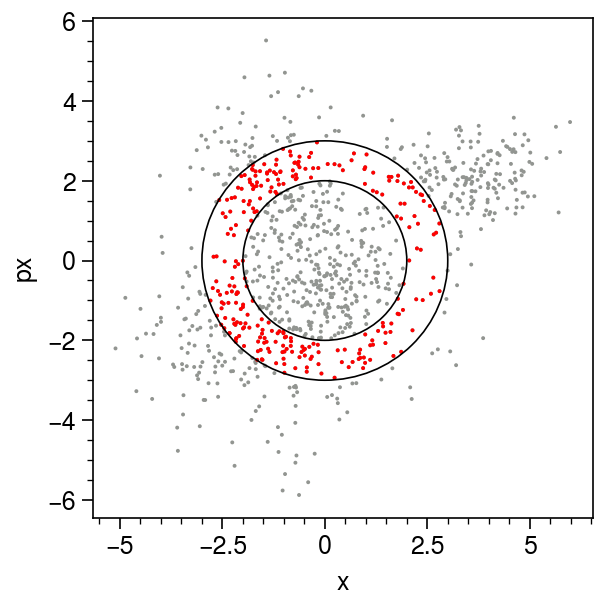

In [7]:
rmin = 2.0
rmax = 3.0
_X1 = ps.cloud.slice_sphere(_X, axis=(0, 1), rmin=rmin, rmax=rmax)

fig, ax = pplt.subplots()
psv.cloud.plot2d(_X, ax=ax, kind='scatter', c='grey')
psv.cloud.plot2d(_X1, ax=ax, kind='scatter', c='red')
for r in [rmin, rmax]:
    psv.circle(r, ax=ax)
ax.format(xlabel=_dims[0], ylabel=_dims[1])

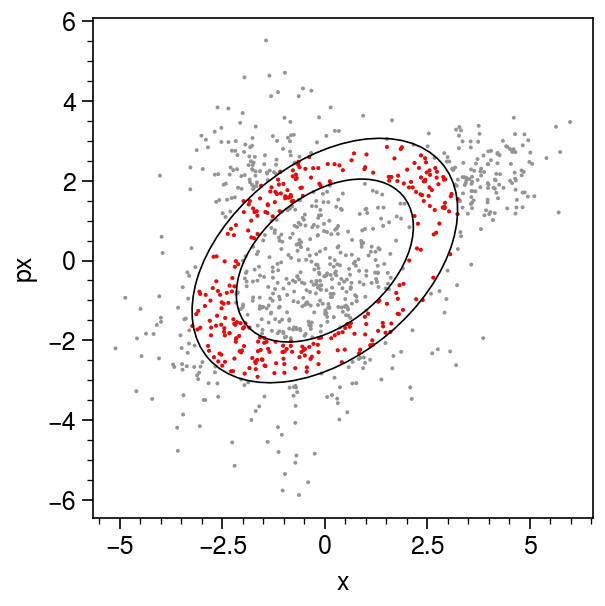

In [8]:
rmin = 1.0
rmax = 1.5
_X1 = ps.cloud.slice_ellipsoid(_X, rmin=rmin, rmax=rmax)

fig, ax = pplt.subplots()
psv.cloud.plot2d(_X, ax=ax, kind='scatter', c='grey')
psv.cloud.plot2d(_X1, ax=ax, kind='scatter', c='red')
for r in [rmin, rmax]:
    psv.cloud.plot_rms_ellipse(X, level=r, ax=ax)
ax.format(xlabel=_dims[0], ylabel=_dims[1])

In [9]:
@interact(rmin=(0.0, 3.0))
def update(rmin):
    @interact(rmax=(rmin, 5.0))
    def update2(rmax):
        _X1 = ps.cloud.slice_ellipsoid(_X, axis=(0, 1), rmin=rmin, rmax=rmax)

        fig, ax = pplt.subplots()
        xmax = 10.0
        ax.format(xlim=(-xmax, xmax), ylim=(-xmax, xmax))
        psv.cloud.plot2d(_X, ax=ax, kind='scatter', c='grey')
        psv.cloud.plot2d(_X1, ax=ax, kind='scatter', c='red')
        for r in [rmin, rmax]:
            psv.cloud.plot_rms_ellipse(X, level=r, ax=ax)
        ax.format(xlabel=_dims[0], ylabel=_dims[1])
        fig.show()

interactive(children=(FloatSlider(value=1.5, description='rmin', max=3.0), Output()), _dom_classes=('widget-in…

### Contour shell slice

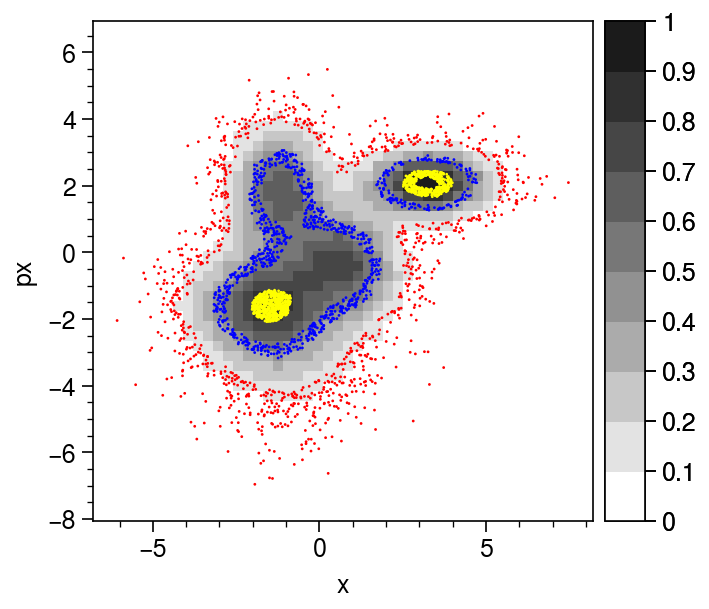

In [10]:
bins = 50
Y = X[:, axis]

fig, ax = pplt.subplots()
psv.cloud.plot2d(
    Y, ax=ax, kind='hist', 
    cmap=pplt.Colormap('mono', left=0.0, right=0.9),
    process_kws=dict(norm='max'),
    colorbar=True,
    bins=bins,
    discrete=True,
)
for lmin, c in zip([0.0, 0.4, 0.8], ['red', 'blue', 'yellow']):
    lmax = lmin + 0.15
    Y1 = ps.cloud.slice_contour(Y, lmin=lmin, lmax=lmax, bins=bins)
    psv.cloud.plot2d(
        ps.cloud.downsample(Y1, 1000), 
        ax=ax, kind='scatter', c=c, s=1.0,
    )
ax.format(xlabel=_dims[0], ylabel=_dims[1])
fig.show()

### Joint plot 

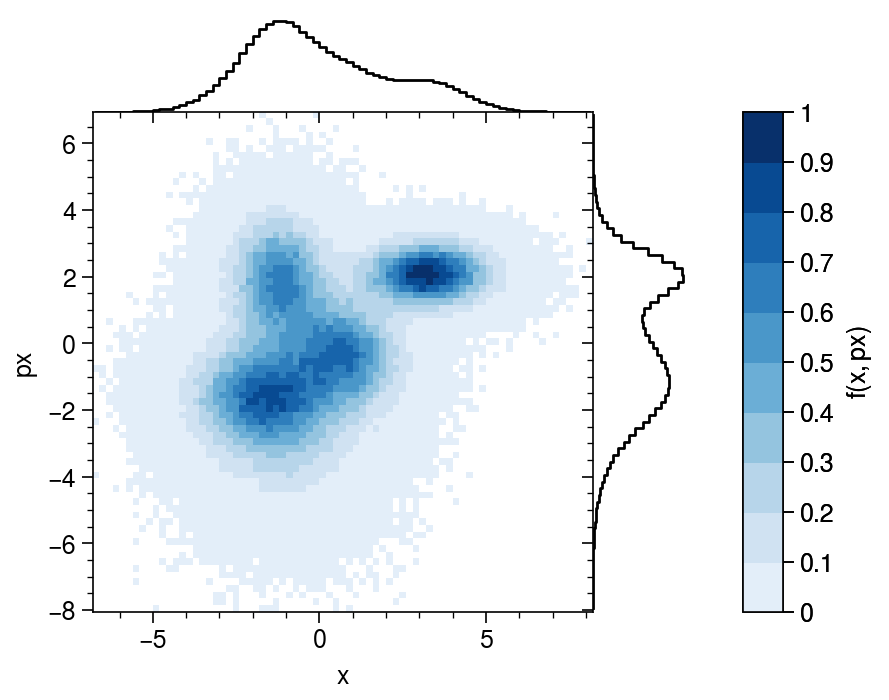

In [11]:
g = psv.JointGrid(
    panel_kws=dict(space=0.0),
    panel_fmt_kws_x=dict(xspineloc='bottom'),
    panel_fmt_kws_y=dict(yspineloc='left'),
    xspineloc='bottom', yspineloc='left'
)
g.plot_cloud(
    Y, marg_kws=dict(kind='step'), marg_hist_kws=dict(bins=75),
    kind='hist', 
    process_kws=dict(norm='max'),
    cmap=pplt.Colormap('blues', left=0.1),
    vmin=0.0, vmax=1.0,
    discrete=True,
    colorbar=True, colorbar_kw=dict(label=r"$f({}, {})$".format(_dims[0], _dims[1])),
)
g.ax.format(xlabel=_dims[0], ylabel=_dims[1])
g.fig.show()

## Corner plot 

In [12]:
alpha = 0.5
cmaps = [pplt.Colormap(name, left=0.2) for name in ['blues', 'reds', 'greens']]
colors = [cmap(0.75) for cmap in cmaps]
plot_kws = dict(
    kind='hist',
    mask=True,
    alpha=alpha,
    rms_ellipse=False,
)
autolim_kws=dict(pad=0.1, zero_center=True)

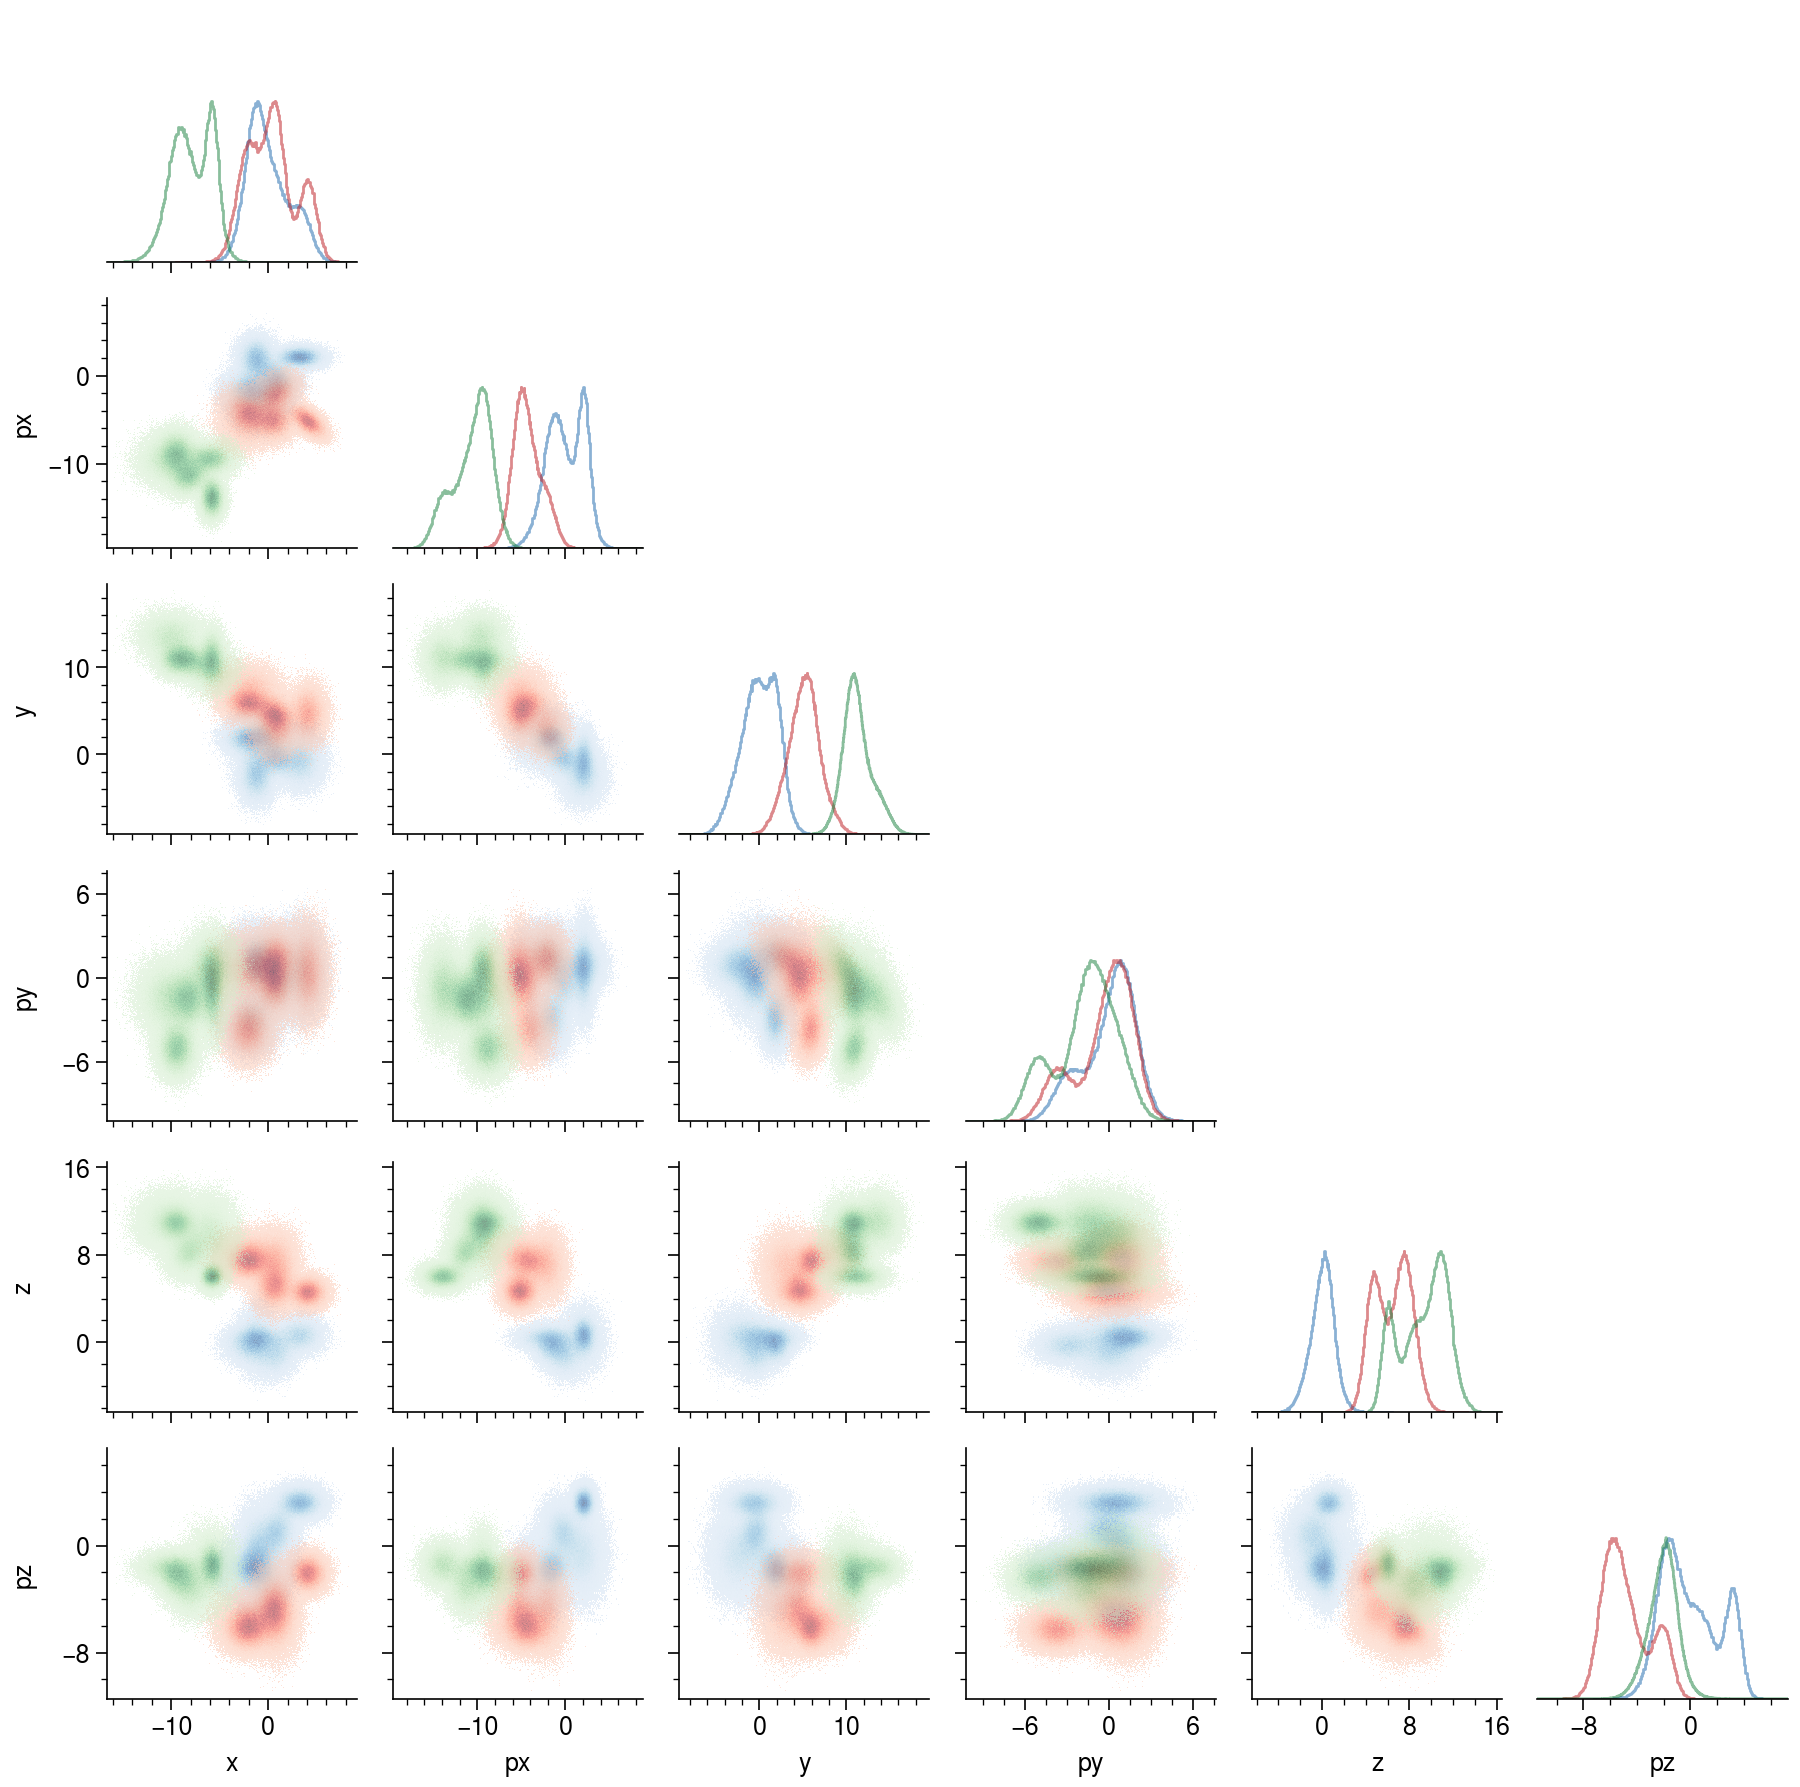

In [13]:
grid = psv.CornerGrid(n=X.shape[1], diag=True, diag_height_frac=0.65)
grid.set_labels(dims)
grid.plot_cloud(
    X, 
    autolim_kws=autolim_kws,
    diag_kws=dict(kind='step', color=colors[0], alpha=alpha),
    bins='auto', 
    cmap=cmaps[0],
    **plot_kws,
)
Y = np.copy(X)
R = ps.ap.phase_adv_matrix(np.radians(45.0), np.radians(20.0), np.radians(-45.0))
for i in range(1, 3):
    Y = ps.cloud.transform_linear(Y, R)
    Y = Y + state.uniform(-7.5, 7.5, size=(1, Y.shape[1]))
    grid.plot_cloud(
        Y, 
        update_limits=True,
        diag_kws=dict(color=colors[i], alpha=alpha),
        cmap=cmaps[i],
        **plot_kws
    )

## Slice matrix plot 

[To do...]

## Interactive slicing

In [14]:
kws = dict(
    profx=True, profy=True,
    prof_kws=dict(color='white'),
    process_kws=dict(norm='max'),
    mask=False,
)
psv.cloud.proj2d_interactive_slice(X, dims=dims, **kws)

interactive(children=(Checkbox(value=False, description='log'), Checkbox(value=False, description='auto plot r…